In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import ElasticNet
import seaborn as sns
import shap
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

In [82]:
# Crea i dati per predire il prezzo tra 3 ggs

stock = "AAPL"

df = pd.read_csv(
    f"csv/{stock}_indicators.csv",
    index_col=0,       # use first column ("Date") as index
    parse_dates=[0],    # parse it as datetime
    date_format="ISO8601" #Specify date fromat
) 

df["Train"] = df["Close"].shift(-3)
df.dropna(subset=['Train'], inplace=True)


Found 44 features with positive correlation to 'Train'.


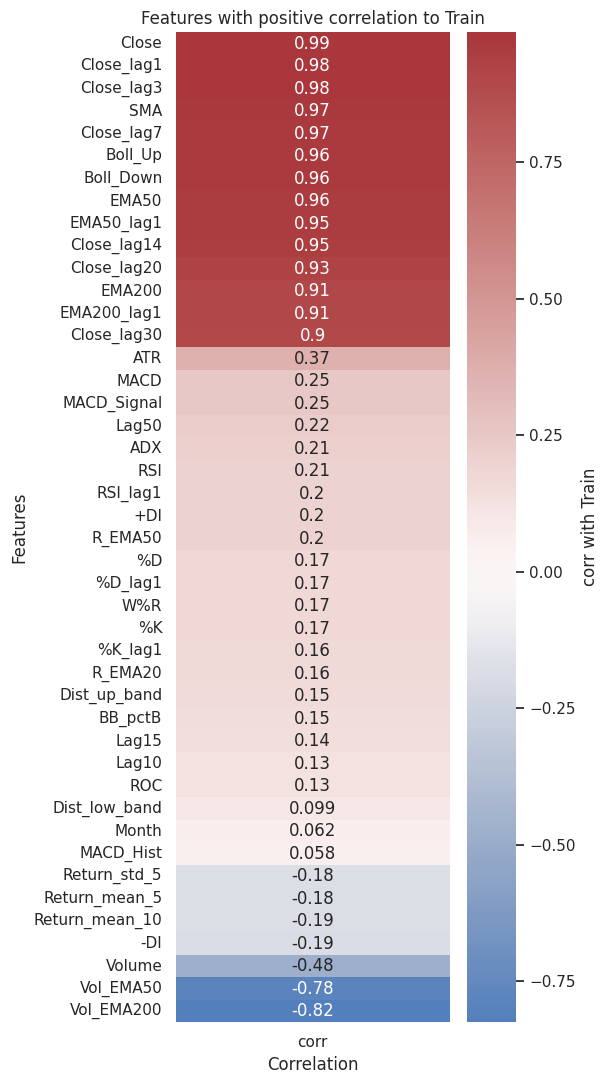

In [83]:
# List features with correlation > 0 w.r.t 'Train' and plot their correlations
if 'Train' not in df.columns:
    print("Column 'Train' not found in df. Run the data prep cell first.")
else:
    # Espressa anche close, per retrocmpatibiltà con il codice sotto stante
    corr = df.corr()
    # extract correlation with Train (drop the Train->Train self-correlation)
    corr_train = corr['Train'].drop(labels=['Train'], errors='ignore')
    significant_features = corr_train[abs(corr_train) > 0.05].sort_values(ascending=False)

    print(f"Found {len(significant_features)} features with positive correlation to 'Train'.")
    plt.figure(figsize=(6, max(4, 0.25 * len(significant_features))))
    sns.set_theme(style='white')
    # Convert to DataFrame for heatmap (required shape: (n, 1))
    pos_df = significant_features.to_frame('corr')
    ax = sns.heatmap(pos_df, annot=True, cmap='vlag', center=0, cbar_kws={'label': 'corr with Train'})
    ax.set_xlabel('Correlation')
    ax.set_ylabel('Features')
    plt.title("Features with positive correlation to Train")
    plt.tight_layout()
    plt.show()

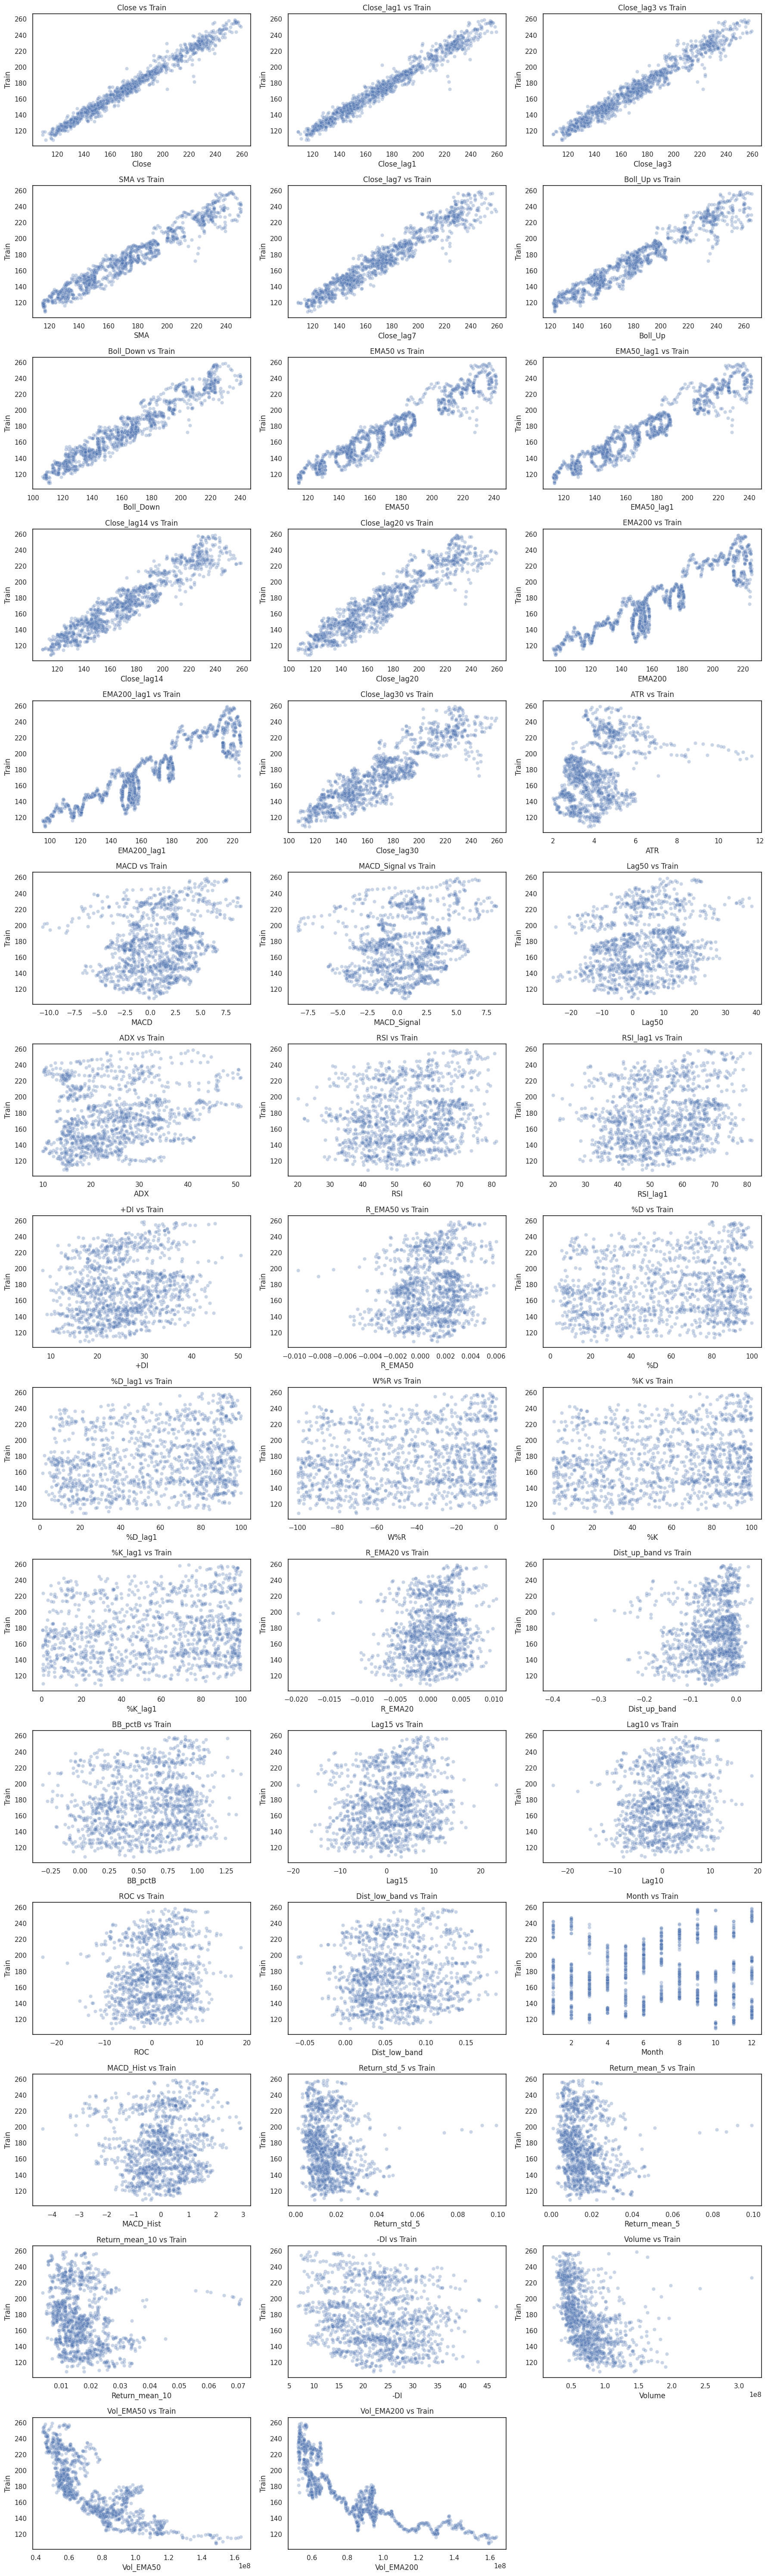

In [84]:
#Scatter plot
cols = list(df[significant_features.index].columns)
n = len(cols)
cols_per_row = 3
rows = (n + cols_per_row - 1) // cols_per_row
fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row * 6, rows * 4), squeeze=False)
axes_flat = axes.flatten()
for idx, col in enumerate(cols):
    ax = axes_flat[idx]
    sns.scatterplot(ax=ax, data=df, x=col, y='Train', alpha=0.3)
    ax.set_title(f"{col} vs Train")
# hide any unused subplots
for ax in axes_flat[n:]:
    ax.set_visible(False)
plt.tight_layout()
plt.show()

In [ ]:
#Data set 
featues = ["Close", "Close_lag1", "Close_lag3", "Close_lag7", "Close_lag14", "Close_lag20", "Close_lag30", "SMA", "Boll_Up", "Boll_Down", "EMA50", "EMA50_lag1", "EMA200", "EMA200_lag1"]

with open("stocks.txt", "r") as f:
    stocks = [line.strip() for line in f if line.strip()]

data_set = []
tscv = TimeSeriesSplit(n_splits=6)
split = pd.Timestamp("2025-06-30")

for stock in stocks:

    dataf = pd.read_csv(
        f"csv/{stock}_indicators.csv",
        index_col=0,       # use first column ("Date") as index
        parse_dates=[0],    # parse it as datetime
        date_format="ISO8601" #Specify date fromat
    ) 

    dataf["Train"] = dataf["Close"].shift(-3)
    dataf.dropna(subset=['Train'], inplace=True)

    X = dataf[featues]
    Y = dataf["Train"]
    
    data_set.append({
        "X_train": X[X.index <= split].copy(),
        "X_test": X[X.index > split].copy(),
        "Y_train": Y[Y.index <= split].copy(),
        "Y_test": Y[Y.index > split].copy(),
        "Reality": dataf.loc[X[X.index > split].index, "Close"].copy()
    })


#for train_idx, test_idx in tscv.split(X):
#    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
#    
#    # Only keep the Close values that correspond to the test indices
#    data_set.append({
#        "X_train": X_train.copy(),
#        "X_test": X_test.copy(),
#        "Y_train": Y_train.copy(),
#        "Y_test": Y_test.copy(),
#        "Reality": df.loc[X_test.index, "Close"].copy()
#    })




Stock: ^GSPC
Best params: {'lasso__alpha': 1.0, 'lasso__max_iter': 10000}
RMSE: 56.5812 | MAE: 47.8811 | R2: 0.8536 | base R2: 0.8576
               coef  mean_abs_shap
Close       645.853    1.18302e+06
Close_lag3  50.5873        91702.7
Boll_Up     25.9795        45782.3
Close_lag1        0              0
Close_lag7        0              0
SMA               0              0
Boll_Down         0              0
EMA50             0              0
EMA50_lag1        0              0
EMA200            0              0
EMA200_lag1       0              0


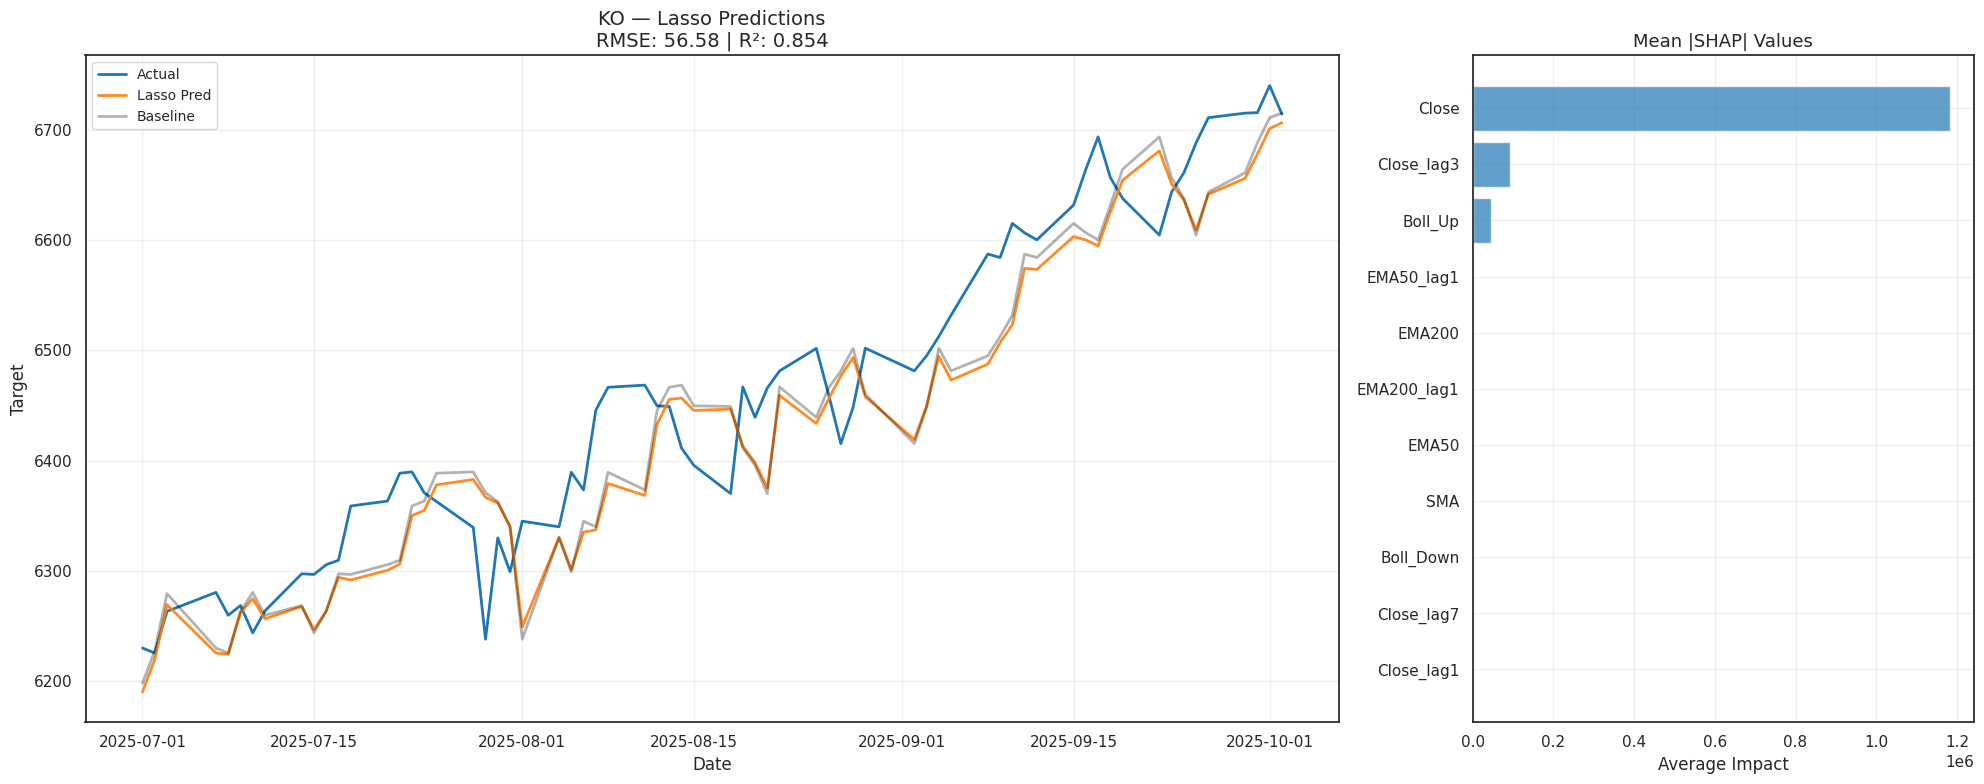

Stock: AAPL
Best params: {'lasso__alpha': 0.1, 'lasso__max_iter': 10000}
RMSE: 7.1493 | MAE: 5.1985 | R2: 0.8140 | base R2: 0.8229
                 coef  mean_abs_shap
Close         31.4183        1682.68
Boll_Up      0.789293        40.1173
EMA200       0.608428        31.7217
Close_lag3   0.522514        26.8597
Close_lag7   0.411964        20.1964
EMA200_lag1 0.0151319       0.788721
Close_lag1          0              0
Boll_Down           0              0
SMA                 0              0
EMA50_lag1          0              0
EMA50               0              0


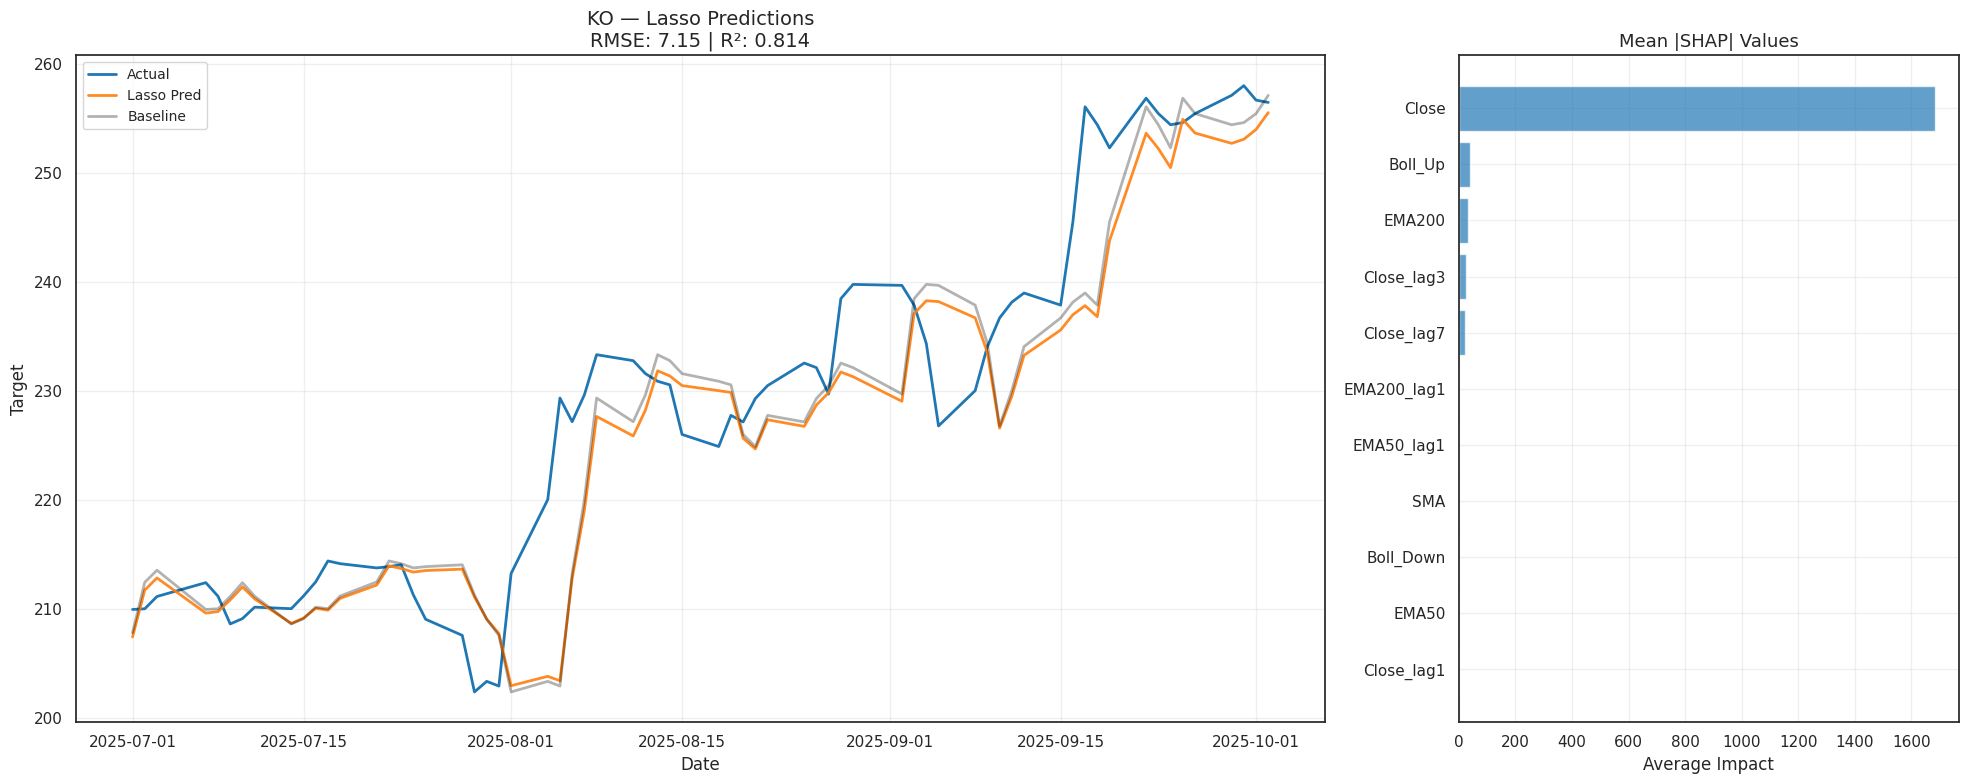

Stock: NVDA
Best params: {'lasso__alpha': 0.1, 'lasso__max_iter': 10000}
RMSE: 5.1179 | MAE: 4.1984 | R2: 0.4047 | base R2: 0.3889
                coef  mean_abs_shap
Close         39.204        4833.12
Boll_Up      3.79572        470.344
Close_lag3   1.89864        230.523
Close_lag1  0.188143        22.9965
Close_lag7         0              0
SMA                0              0
Boll_Down          0              0
EMA50              0              0
EMA50_lag1         0              0
EMA200             0              0
EMA200_lag1        0              0


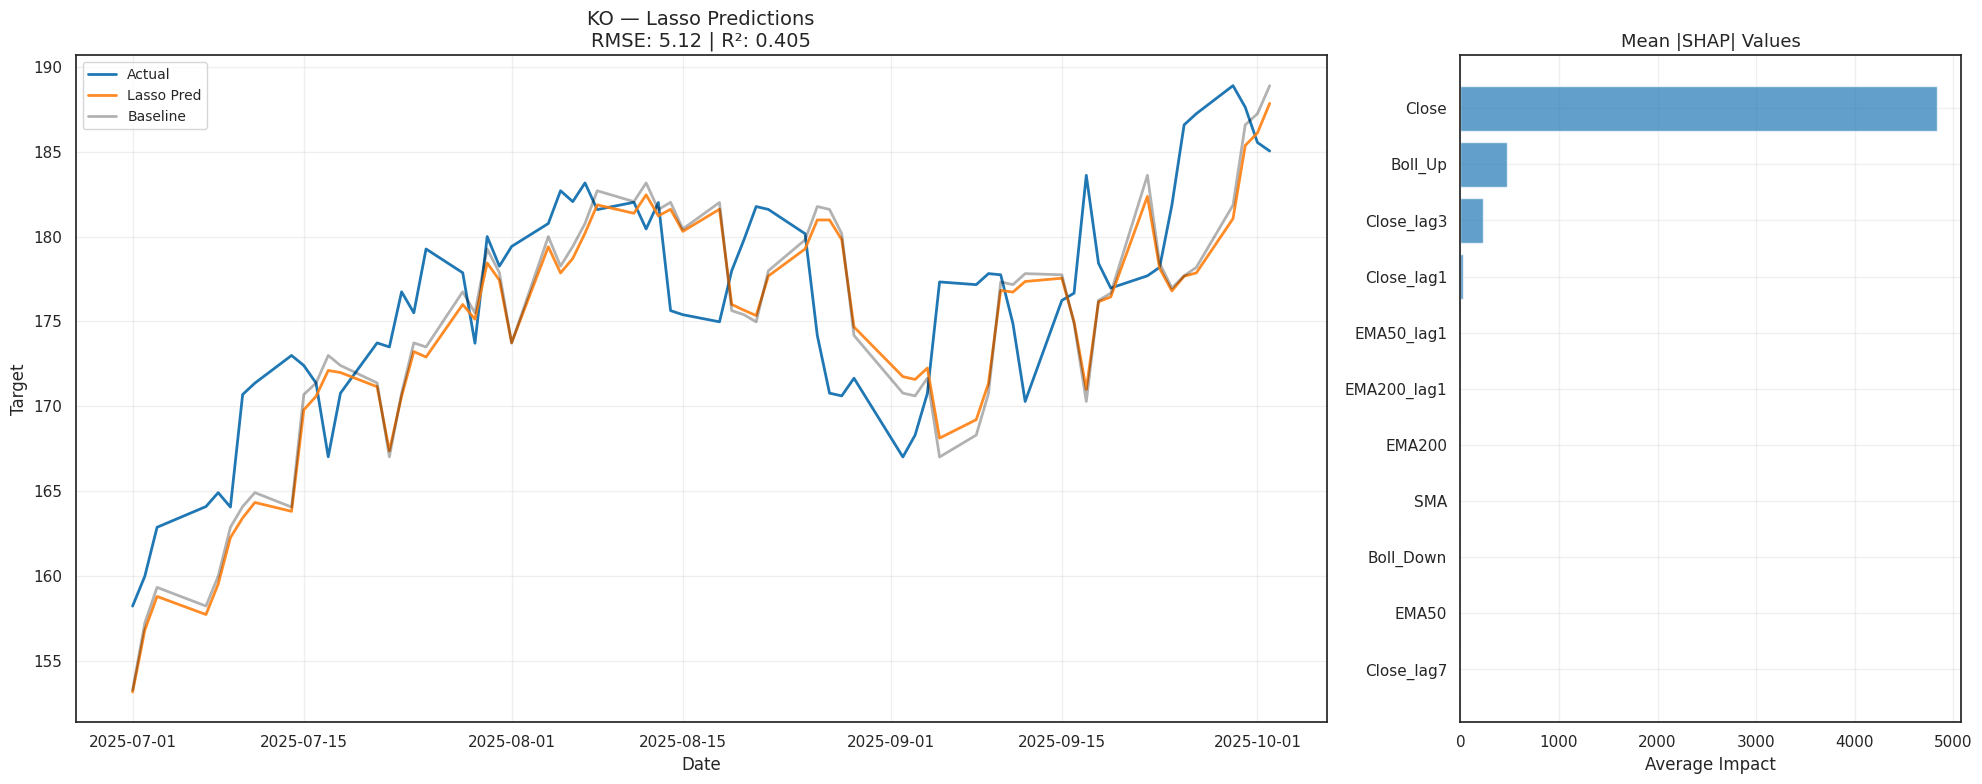

Stock: KO
Best params: {'lasso__alpha': 0.1, 'lasso__max_iter': 10000}
RMSE: 0.8269 | MAE: 0.6812 | R2: 0.7099 | base R2: 0.6728
                 coef  mean_abs_shap
Close         5.24657        41.6197
Close_lag3  0.0923547       0.755704
EMA200       0.089041       0.835574
Close_lag1          0              0
Close_lag7          0              0
Boll_Up             0              0
SMA                 0              0
Boll_Down           0              0
EMA50               0              0
EMA50_lag1          0              0
EMA200_lag1         0              0


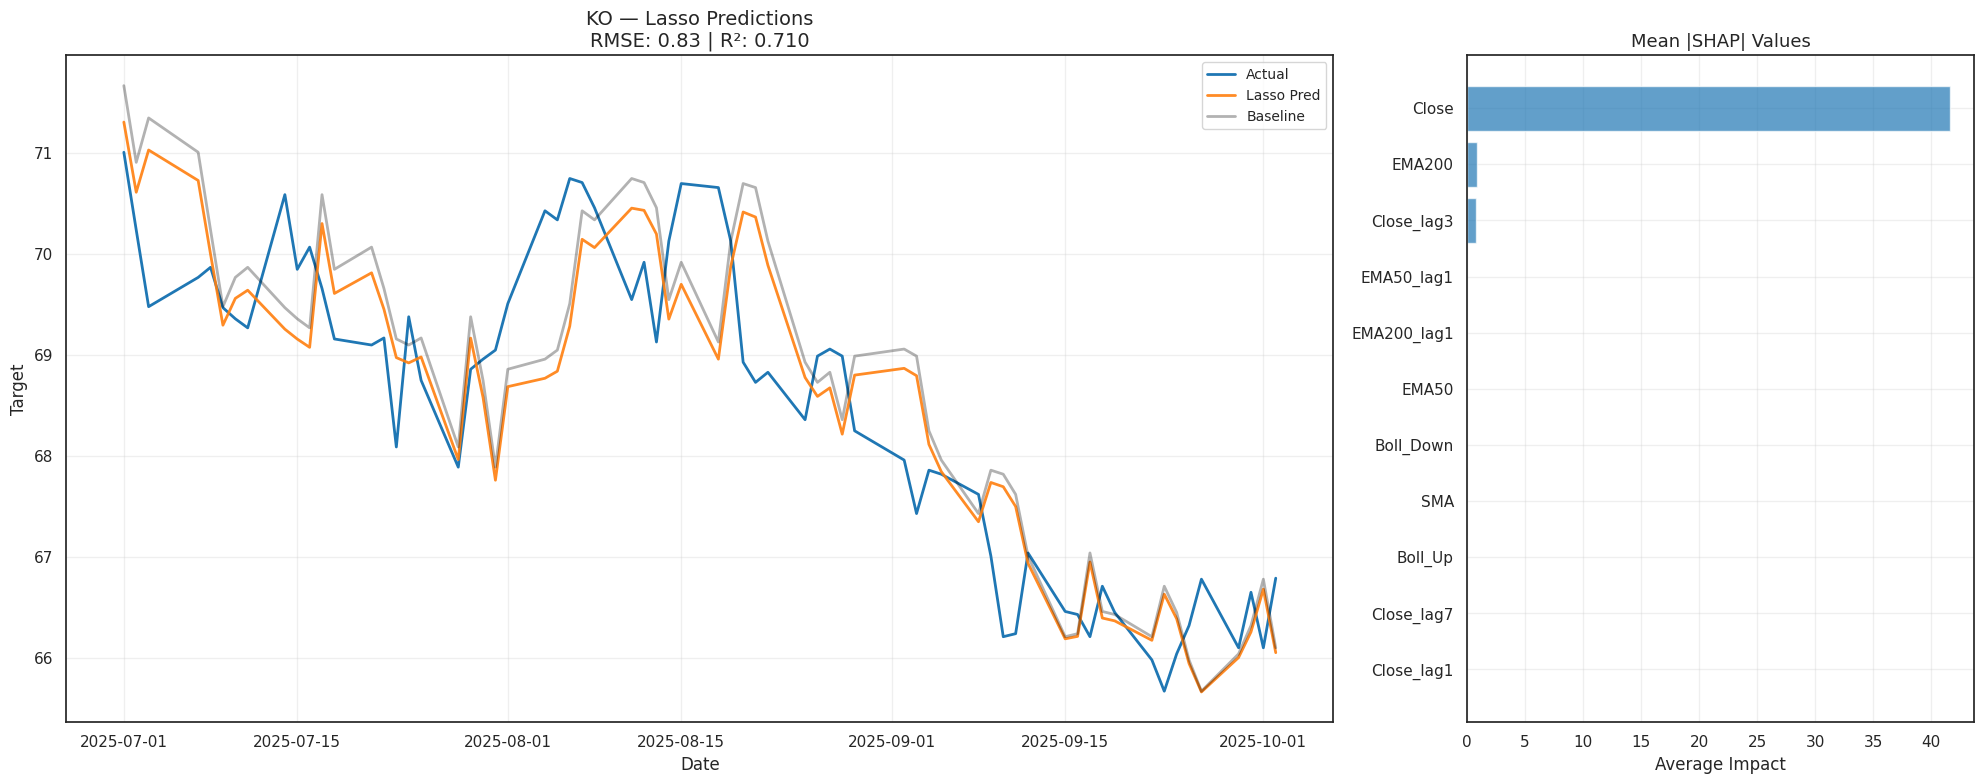

In [86]:
#Lasso regression
for i, data in enumerate(data_set):
    pipe = make_pipeline(StandardScaler(), Lasso(random_state=42, max_iter=20000))

    param_grid = {
        'lasso__alpha': [0.1, 0.5, 1.0, 2.0], 
        'lasso__max_iter': [10000, 50000, 100000]
    }
    gs = GridSearchCV(pipe, param_grid, scoring='r2', cv=3, n_jobs=-1, verbose=0)
    gs.fit(data["X_train"], data["Y_train"])

    best = gs.best_estimator_
    y_pred = best.predict(data["X_test"])

    mse = mean_squared_error(data["Y_test"], y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(data["Y_test"], y_pred)
    r2 = r2_score(data["Y_test"], y_pred)
    base = r2_score(data["Y_test"], data["Reality"])

    print(f"Stock: {stocks[i]}")
    print(f"Best params: {gs.best_params_}")
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f} | base R2: {base:.4f}")

    # coefficients
    lasso = best.named_steps['lasso']
    coefs = pd.Series(lasso.coef_, index=data["X_train"].columns)

    # compute SHAP values (try recommended masker, fallback to Explainer)
    shap_values = None
    try:
        masker = shap.maskers.Independent(data["X_train"])  # type: ignore
        explainer = shap.LinearExplainer(lasso, masker=masker)
        shap_values = explainer(data["X_test"])
    except Exception:
        try:
            explainer = shap.Explainer(lasso, data["X_train"])
            shap_values = explainer(data["X_test"])
        except Exception:
            shap_values = None

    # prepare combined table (coef + mean |SHAP|)
    if shap_values is None:
        combined = pd.DataFrame({"coef": coefs})
        combined["abs_coef"] = combined["coef"].abs()
        combined = combined.sort_values("abs_coef", ascending=False)
        print("SHAP unavailable — coefficients ordered by |coef|:")
        print(combined[["coef"]].to_string(float_format=lambda x: f"{x:.6g}"))
    else:
        if hasattr(shap_values, "values"):
            sv = shap_values.values
        else:
            sv = shap_values
        if isinstance(sv, list):
            sv = sv[0]
        mean_abs = np.mean(np.abs(sv), axis=0)
        shap_series = pd.Series(mean_abs, index=data["X_test"].columns)

        combined = pd.DataFrame({
            "coef": coefs,
            "abs_coef": coefs.abs(),
            "mean_abs_shap": shap_series
        }).fillna(0)

        combined = combined.sort_values("abs_coef", ascending=False)
        print(combined[["coef", "mean_abs_shap"]].to_string(float_format=lambda x: f"{x:.6g}"))

    # --- ONE figure with two panels ---
    fig, (ax_main, ax_shap) = plt.subplots(
        1, 2,
        figsize=(20, 8),                   # this WILL now control the size
        gridspec_kw={'width_ratios': [2.5, 1]}
    )

    # ---- MAIN PLOT ----
    ax_main.plot(data["Y_test"].index, data["Y_test"], label='Actual', color='#1f77b4', linewidth=2)
    ax_main.plot(data["Y_test"].index, y_pred, label='Lasso Pred', color='#ff7f0e', linewidth=2, alpha=0.9)
    ax_main.plot(data["Y_test"].index, data["Reality"], label='Baseline', color='#000000', linewidth=2, alpha=0.3)

    ax_main.set_title(f"{stock} — Lasso Predictions\nRMSE: {rmse:.2f} | R²: {r2:.3f}", fontsize=14)
    ax_main.set_xlabel("Date", fontsize=12)
    ax_main.set_ylabel("Target", fontsize=12)
    ax_main.legend(fontsize=10)
    ax_main.grid(alpha=0.3)

    # ---- SHAP PLOT ----
    try:
        if hasattr(shap_values, "values"):
            sv = shap_values.values # type: ignore
        else:
            sv = shap_values
        if isinstance(sv, list):
            sv = sv[0]

        # Compute mean absolute SHAP values
        mean_abs = np.mean(np.abs(sv), axis=0)
        shap_series = pd.Series(mean_abs, index=data["X_test"].columns)
        shap_series = shap_series.sort_values(ascending=True)

        # Horizontal bar chart
        ax_shap.barh(shap_series.index, shap_series.values, color="#1f77b4", alpha=0.7)
        ax_shap.set_title("Mean |SHAP| Values", fontsize=13)
        ax_shap.set_xlabel("Average Impact", fontsize=12)
        ax_shap.grid(alpha=0.3)
    except Exception as e:
        ax_shap.text(0.5, 0.5, f"SHAP plot failed:\n{e}", ha='center', va='center', fontsize=10)
        ax_shap.set_axis_off()

    plt.tight_layout()
    plt.show()

Stock: ^GSPC
Best params: {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.9}
RMSE: 57.8352 | MAE: 49.4472 | R2: 0.8470 | base R2: 0.8576
                coef  mean_abs_shap
Close        561.543    1.02859e+06
Close_lag1   74.7471         136063
Close_lag3   65.2105         118211
Boll_Up      40.4245        71237.9
Boll_Down   -20.3933        36462.4
EMA50        15.9316        26575.6
EMA200_lag1 -9.82419        14755.9
EMA200      -3.98463        5997.96
Close_lag7  -3.35861        6009.55
SMA          2.05851        3654.06
EMA50_lag1         0              0


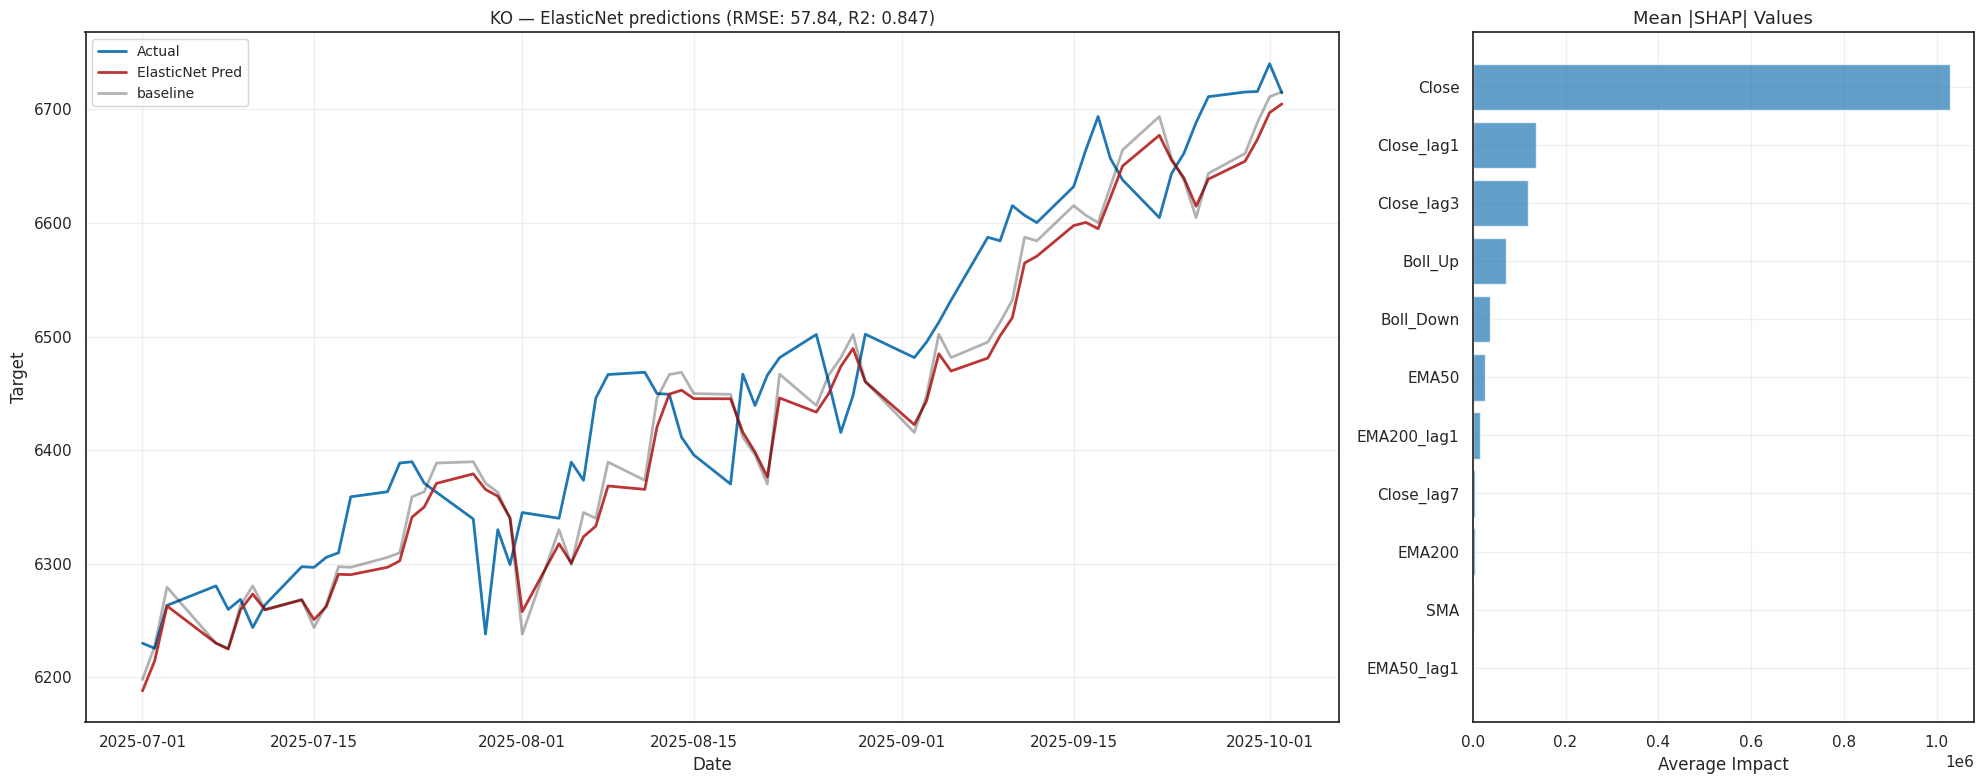

Stock: AAPL
Best params: {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.9}
RMSE: 7.0805 | MAE: 5.1301 | R2: 0.8175 | base R2: 0.8229
                 coef  mean_abs_shap
Close         29.6653        1588.79
Boll_Up       1.38703        70.4987
Close_lag3    1.27213        65.3934
Close_lag1    1.01564        53.3044
EMA200       0.847949        44.2097
EMA50_lag1  -0.566232        24.7713
Close_lag7   0.496865        24.3586
EMA50       -0.435077         19.201
EMA200_lag1  0.177615        9.25782
Boll_Down           0              0
SMA                 0              0


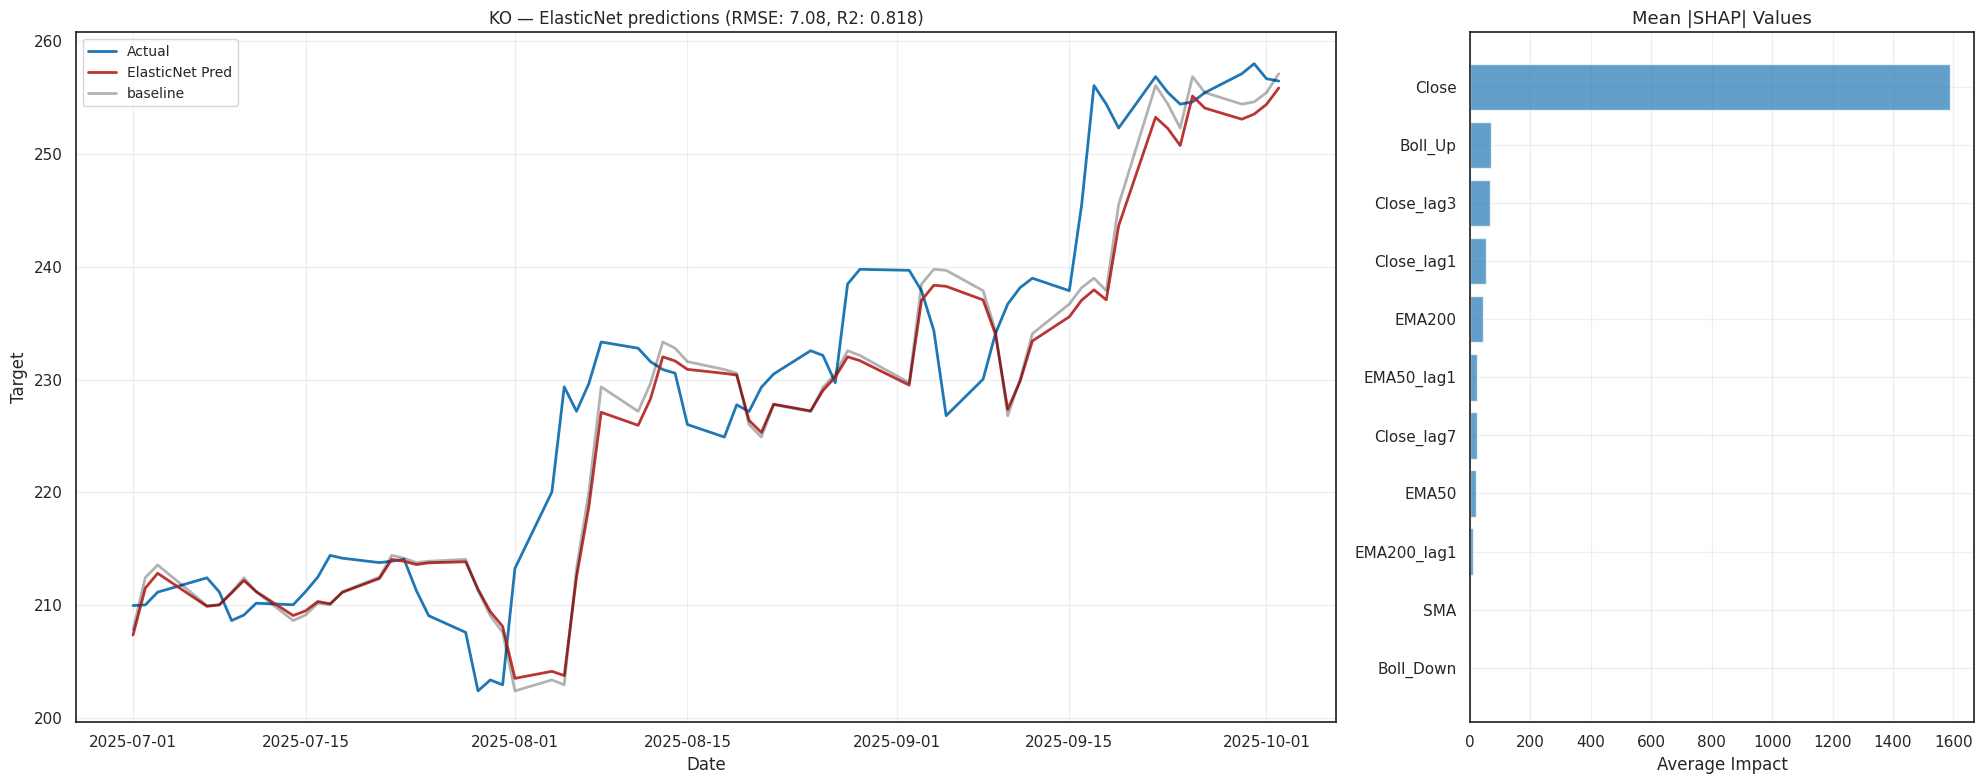

Stock: NVDA
Best params: {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.9}
RMSE: 5.0614 | MAE: 4.1861 | R2: 0.4178 | base R2: 0.3889
                 coef  mean_abs_shap
Close         31.0305        3825.49
Close_lag1    7.02832        859.061
Boll_Up       6.31037        781.945
Close_lag3    2.38501        289.576
EMA50_lag1   -1.62985        179.185
EMA50       -0.526927        58.2061
EMA200       0.473241        44.6848
EMA200_lag1 0.0964396        9.07813
Boll_Down          -0              0
Close_lag7         -0              0
SMA                 0              0


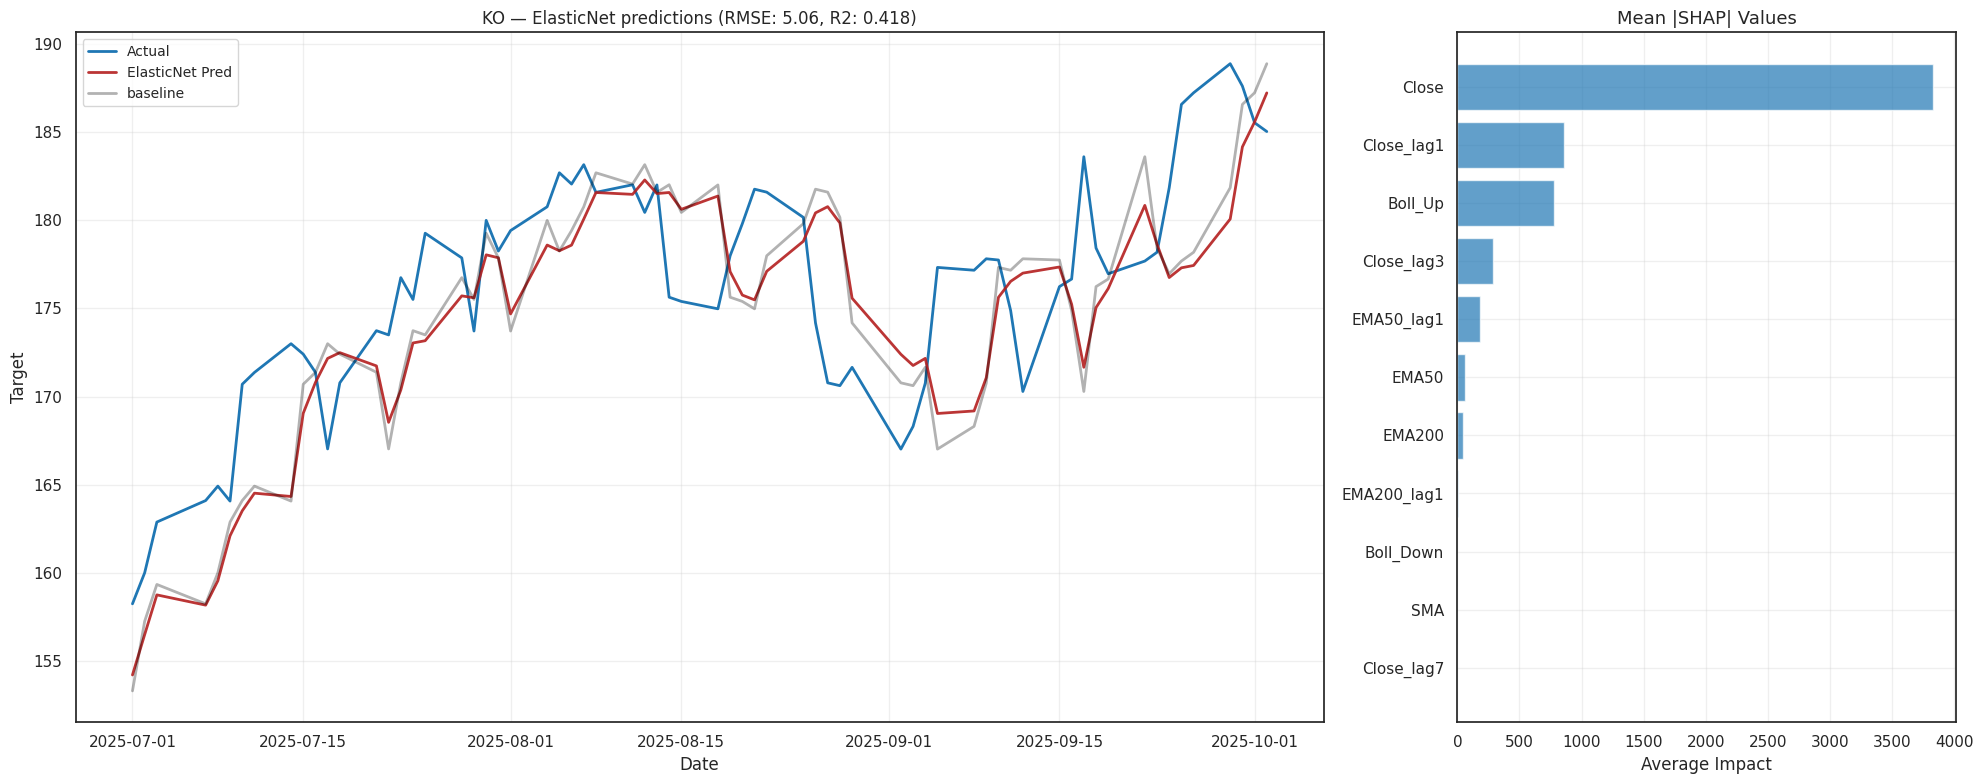

Stock: KO
Best params: {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.9}
RMSE: 0.8482 | MAE: 0.6947 | R2: 0.6948 | base R2: 0.6728
                 coef  mean_abs_shap
Close         4.99917        39.6572
Close_lag3   0.254426        2.08187
Close_lag1   0.231071        1.85275
EMA200       0.149448        1.40244
Boll_Down   -0.139777        1.32512
EMA200_lag1 0.0139055       0.130694
Boll_Up     0.0130868        0.10946
Close_lag7          0              0
SMA                 0              0
EMA50_lag1         -0              0
EMA50              -0              0


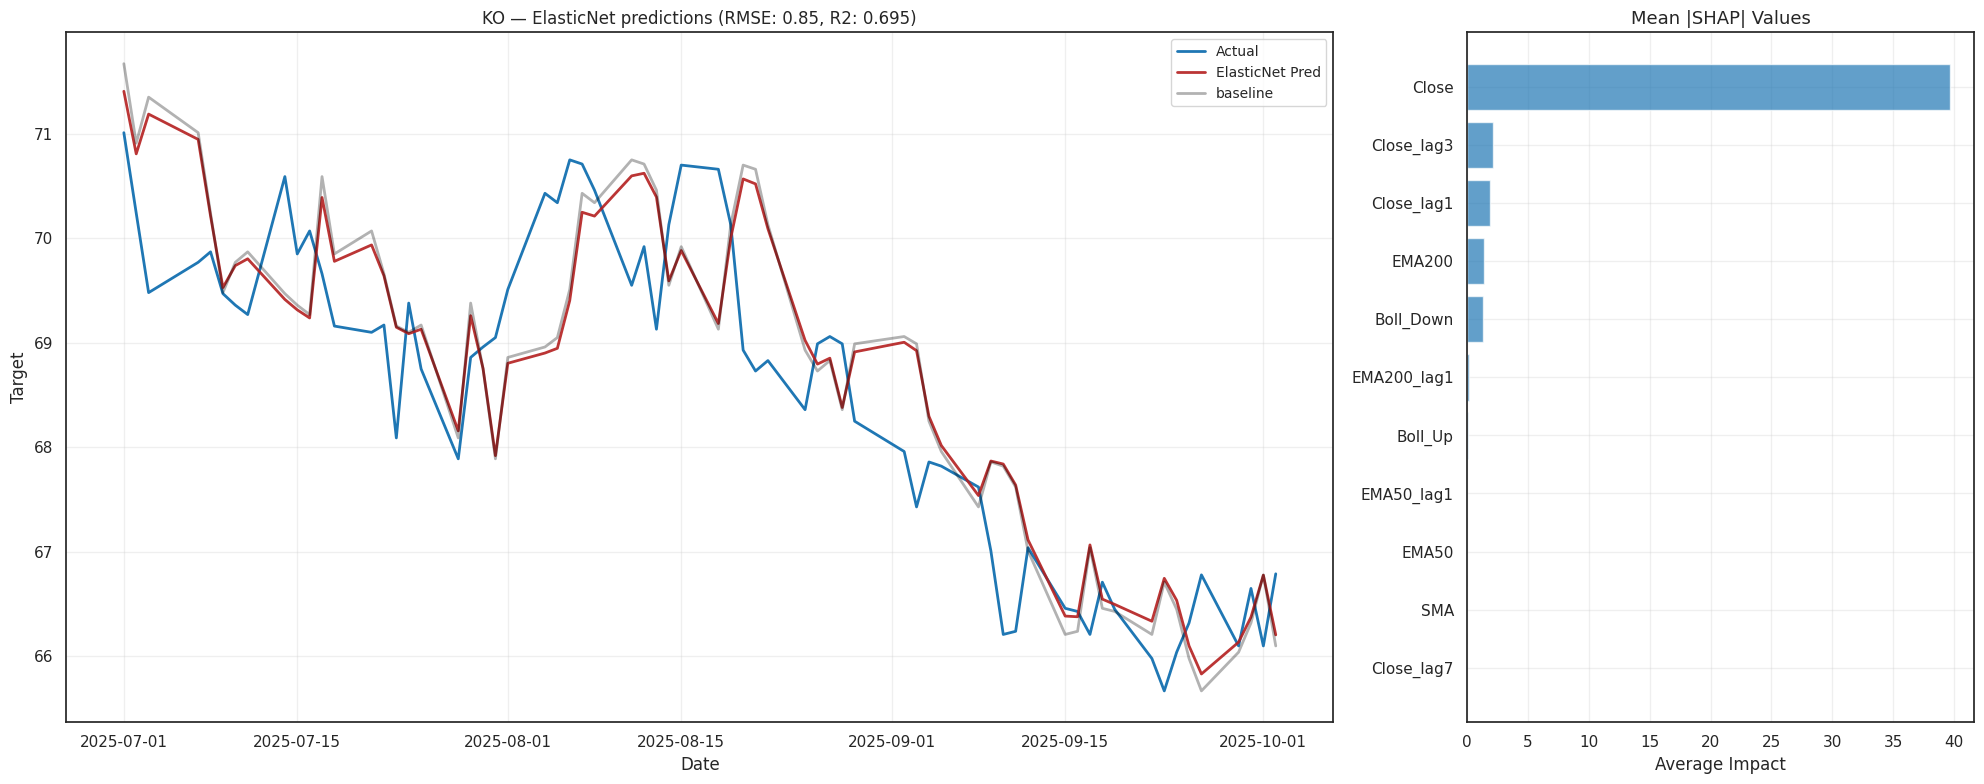

In [87]:
# Elatic-net
for i, data in enumerate(data_set):
    pipe = make_pipeline(StandardScaler(), ElasticNet(random_state=42, max_iter=20000))

    param_grid = {
        'elasticnet__alpha': [0.01, 0.1, 0.5, 1.0],
        'elasticnet__l1_ratio': [0.1, 0.5, 0.9]
    }
    gs = GridSearchCV(pipe, param_grid, scoring='r2', cv=3, n_jobs=-1, verbose=0)
    gs.fit(data["X_train"], data["Y_train"])

    best = gs.best_estimator_
    y_pred = best.predict(data["X_test"])

    mse = mean_squared_error(data["Y_test"], y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(data["Y_test"], y_pred)
    r2 = r2_score(data["Y_test"], y_pred)
    base = r2_score(data["Y_test"], data["Reality"])

    print(f"Stock: {stocks[i]}")
    print(f"Best params: {gs.best_params_}")
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f} | base R2: {base:.4f}")

    # display top coefficients
    try:
        enet = best.named_steps['elasticnet']
        coefs = pd.Series(enet.coef_, index=data["X_train"].columns)
    except Exception:
        pass

    # compute SHAP values (try recommended masker, fallback to Explainer)
    shap_values = None
    try:
        masker = shap.maskers.Independent(data["X_train"])  # type: ignore
        explainer = shap.LinearExplainer(enet, masker=masker)
        shap_values = explainer(data["X_test"])
    except Exception:
        try:
            explainer = shap.Explainer(enet, data["X_train"])
            shap_values = explainer(data["X_test"])
        except Exception:
            shap_values = None

    # prepare combined table (coef + mean |SHAP|)
    if shap_values is None:
        combined = pd.DataFrame({"coef": coefs})
        combined["abs_coef"] = combined["coef"].abs()
        combined = combined.sort_values("abs_coef", ascending=False)
        print("SHAP unavailable — coefficients ordered by |coef|:")
        print(combined[["coef"]].to_string(float_format=lambda x: f"{x:.6g}"))
    else:
        if hasattr(shap_values, "values"):
            sv = shap_values.values
        else:
            sv = shap_values
        if isinstance(sv, list):
            sv = sv[0]
        mean_abs = np.mean(np.abs(sv), axis=0)
        shap_series = pd.Series(mean_abs, index=data["X_test"].columns)

        combined = pd.DataFrame({
            "coef": coefs,
            "abs_coef": coefs.abs(),
            "mean_abs_shap": shap_series
        }).fillna(0)

        combined = combined.sort_values("abs_coef", ascending=False)
        print(combined[["coef", "mean_abs_shap"]].to_string(float_format=lambda x: f"{x:.6g}"))

    # --- ONE figure with two panels ---
    fig, (ax_main, ax_shap) = plt.subplots(
        1, 2,
        figsize=(20, 8),                   # this WILL now control the size
        gridspec_kw={'width_ratios': [2.5, 1]}
    )

    # ---- MAIN PLOT ----
    ax_main.plot(data["Y_test"].index, data["Y_test"], label='Actual', color='#1f77b4', linewidth=2)
    ax_main.plot(data["Y_test"].index, y_pred, label='ElasticNet Pred', color='#b41f1f', linewidth=2, alpha=0.9)
    ax_main.plot(data["Y_test"].index, data["Reality"], label='baseline', color='#000000', linewidth=2, alpha=0.3)

    ax_main.set_title(f"{stock} — ElasticNet predictions (RMSE: {rmse:.2f}, R2: {r2:.3f})")
    ax_main.set_xlabel("Date", fontsize=12)
    ax_main.set_ylabel("Target", fontsize=12)
    ax_main.legend(fontsize=10)
    ax_main.grid(alpha=0.3)

    # ---- SHAP PLOT (manual bar chart) ----
    try:
        if hasattr(shap_values, "values"):
            sv = shap_values.values # type: ignore
        else:
            sv = shap_values
        if isinstance(sv, list):
            sv = sv[0]

        # Compute mean absolute SHAP values
        mean_abs = np.mean(np.abs(sv), axis=0)
        shap_series = pd.Series(mean_abs, index=data["X_test"].columns)
        shap_series = shap_series.sort_values(ascending=True)

        # Horizontal bar chart
        ax_shap.barh(shap_series.index, shap_series.values, color="#1f77b4", alpha=0.7)
        ax_shap.set_title("Mean |SHAP| Values", fontsize=13)
        ax_shap.set_xlabel("Average Impact", fontsize=12)
        ax_shap.grid(alpha=0.3)
    except Exception as e:
        ax_shap.text(0.5, 0.5, f"SHAP plot failed:\n{e}", ha='center', va='center', fontsize=10)
        ax_shap.set_axis_off()

    plt.tight_layout()
    plt.show()

Stock: ^GSPC
Best params: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.01, 'xgb__min_child_weight': 5, 'xgb__n_estimators': 300, 'xgb__reg_lambda': 2, 'xgb__subsample': 0.4}
RMSE: 589.3945 | MAE: 569.1357 | R2: -14.8862 | base R2: 0.8576
Top features (ordered by importance) with corresponding mean |SHAP|:
                  coef  mean_abs_shap
SMA           0.237654        269.026
Close_lag1     0.18652        189.089
Close          0.14329        432.416
Close_lag7    0.130055        107.388
Close_lag3   0.0988552        92.8314
EMA200_lag1  0.0806573        26.5653
Boll_Down    0.0795668        103.209
EMA200       0.0281452        45.7516
Boll_Up      0.0116087        21.6891
EMA50       0.00235147        7.60232
EMA50_lag1  0.00129737        9.35653


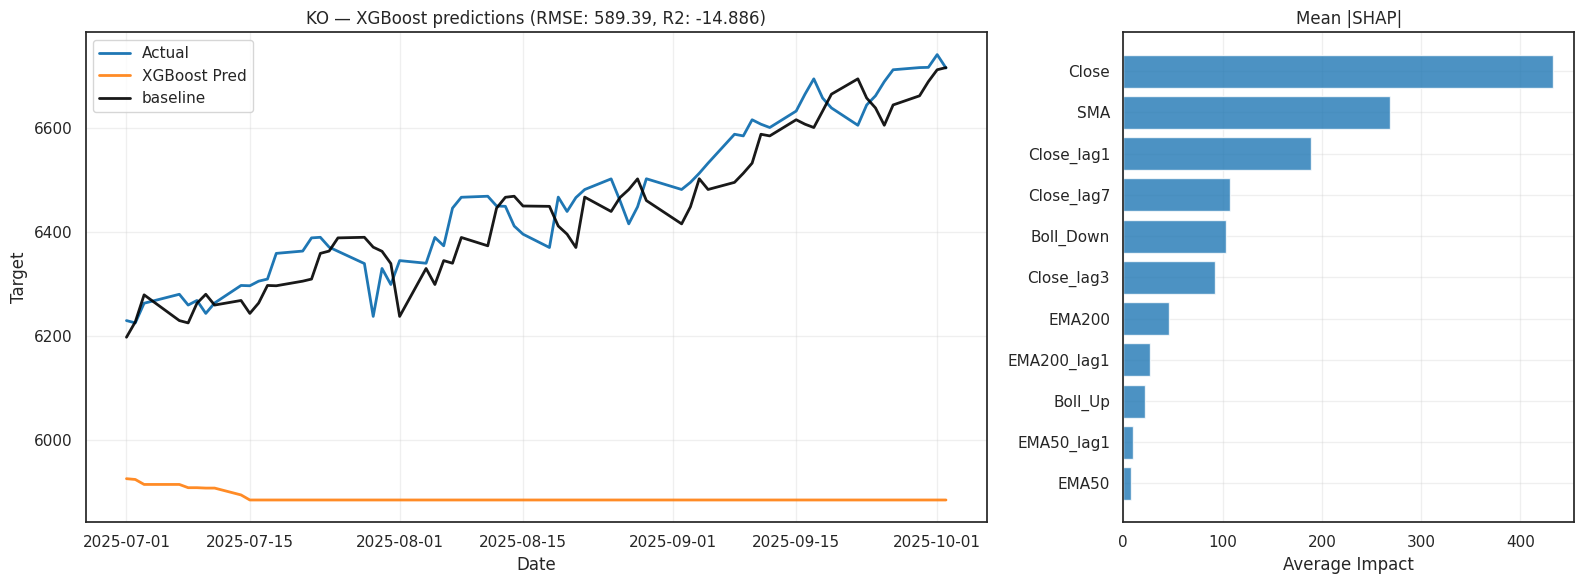

Stock: AAPL
Best params: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.01, 'xgb__min_child_weight': 5, 'xgb__n_estimators': 800, 'xgb__reg_lambda': 2, 'xgb__subsample': 0.4}
RMSE: 7.1992 | MAE: 5.4486 | R2: 0.8114 | base R2: 0.8229
Top features (ordered by importance) with corresponding mean |SHAP|:
                  coef  mean_abs_shap
Close         0.428096        28.5451
Close_lag1    0.307652         10.822
Close_lag3    0.159977        4.90854
Boll_Up      0.0257804        3.26817
SMA           0.019516        1.85755
Close_lag7   0.0187264        1.86451
Boll_Down    0.0125757       0.812693
EMA200      0.00876344        1.42012
EMA50       0.00701954       0.277015
EMA50_lag1  0.00619815       0.618214
EMA200_lag1  0.0056961       0.571115


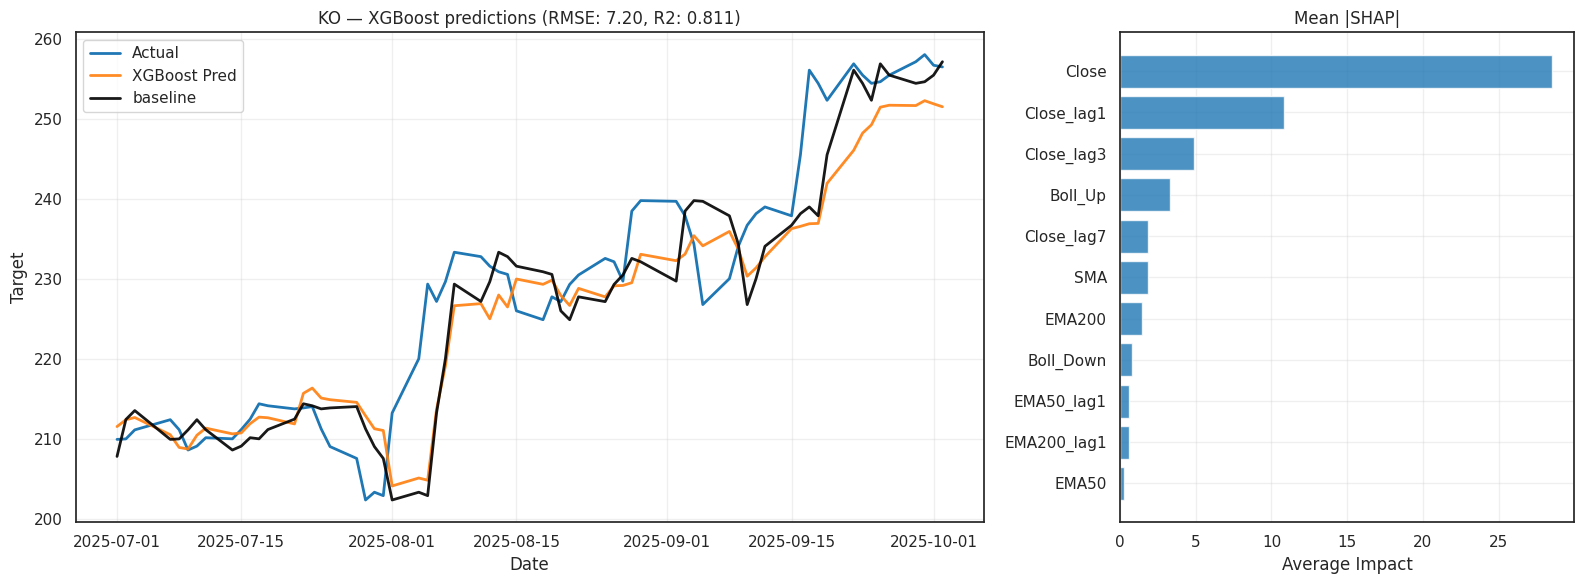

Stock: NVDA
Best params: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.01, 'xgb__min_child_weight': 5, 'xgb__n_estimators': 800, 'xgb__reg_lambda': 2, 'xgb__subsample': 0.4}
RMSE: 34.1683 | MAE: 33.4033 | R2: -25.5319 | base R2: 0.3889
Top features (ordered by importance) with corresponding mean |SHAP|:
                  coef  mean_abs_shap
Close_lag3    0.203337        15.5032
SMA           0.201129        10.9926
Close         0.189755         29.298
Close_lag1    0.162305        16.0326
Close_lag7    0.129672         9.6606
Boll_Up      0.0534627        4.18561
Boll_Down     0.049171        4.74428
EMA50       0.00484426        2.11694
EMA50_lag1  0.00230607        2.72739
EMA200      0.00224517        2.87209
EMA200_lag1 0.00177265        1.34082


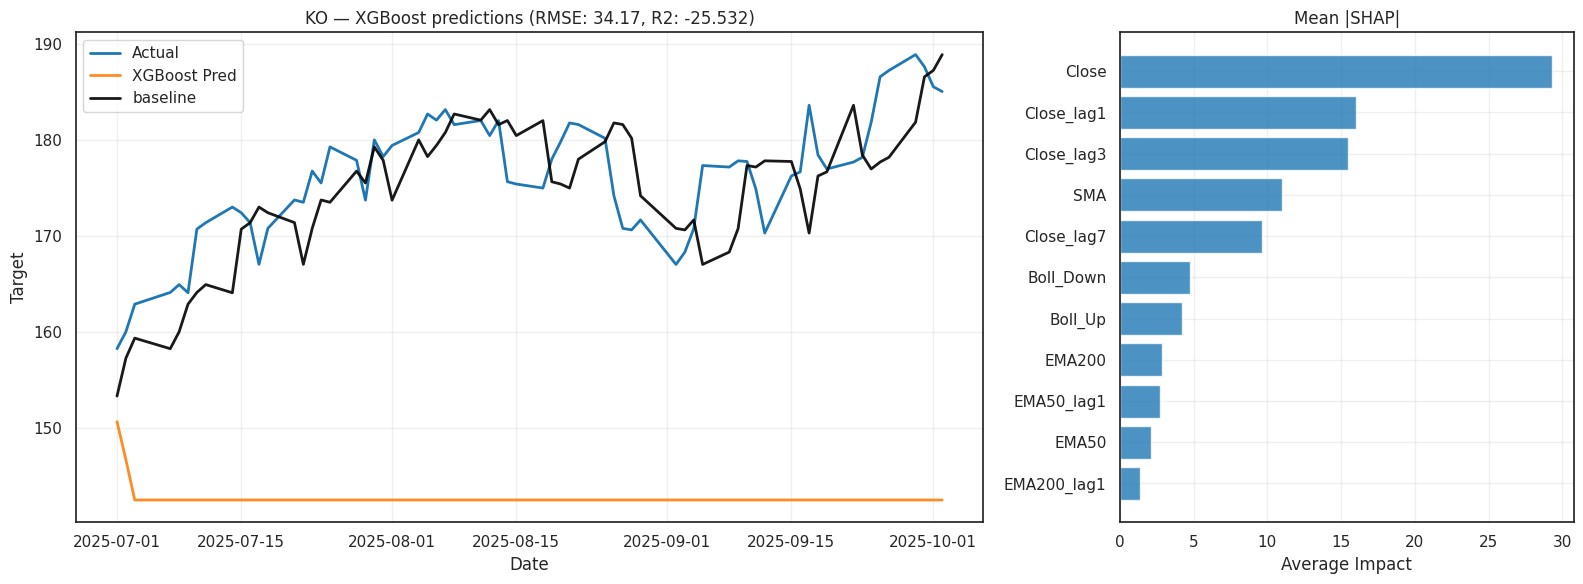

Stock: KO
Best params: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.01, 'xgb__min_child_weight': 5, 'xgb__n_estimators': 800, 'xgb__reg_lambda': 2, 'xgb__subsample': 0.4}
RMSE: 1.2944 | MAE: 1.0823 | R2: 0.2892 | base R2: 0.6728
Top features (ordered by importance) with corresponding mean |SHAP|:
                  coef  mean_abs_shap
Close          0.49406        5.35874
Close_lag1     0.28108        1.76994
Close_lag3    0.142425        1.16017
EMA200       0.0145307       0.436164
EMA200_lag1  0.0130688       0.122624
Boll_Up      0.0127189       0.113421
SMA          0.0104741      0.0655466
EMA50        0.0089092       0.045356
Close_lag7  0.00768271      0.0527571
EMA50_lag1   0.0076451       0.103166
Boll_Down   0.00740638      0.0600912


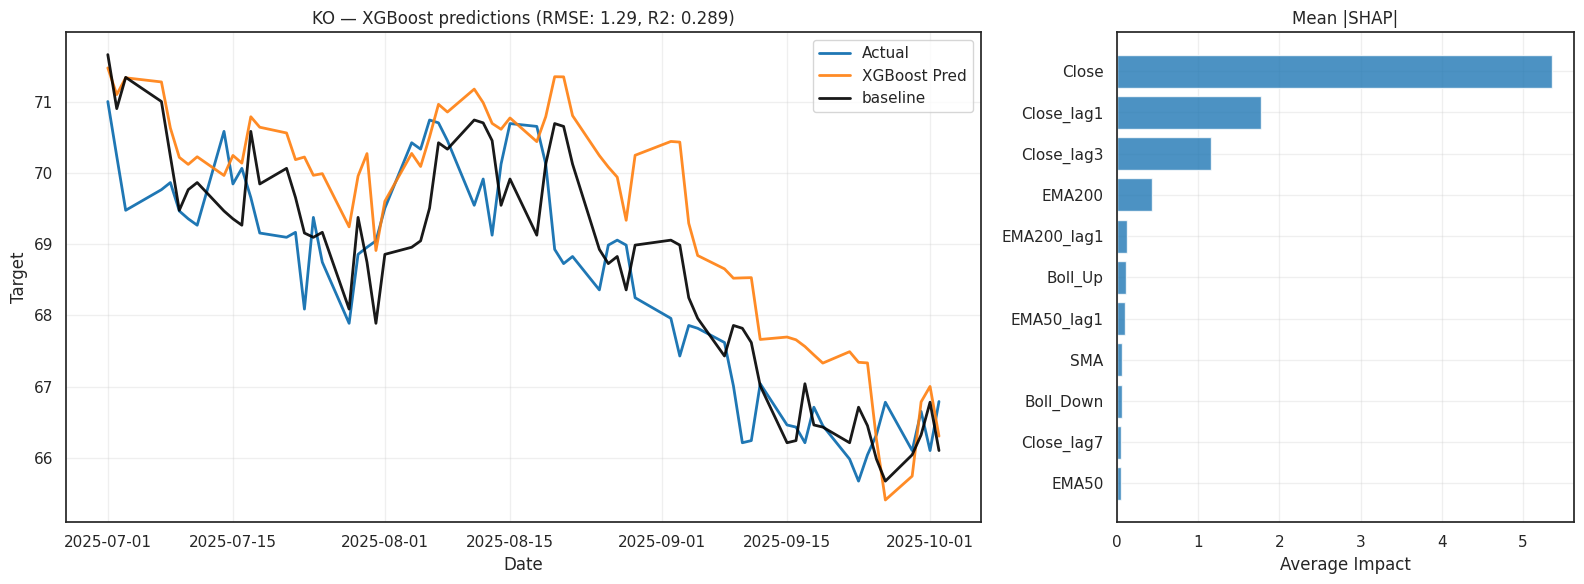

In [88]:
for i,data in enumerate(data_set):
    pipe = Pipeline([('xgb', XGBRegressor(objective='reg:squarederror', random_state=42, verbosity=0))])

    param_grid = {
        'xgb__n_estimators': [300, 800, 1000],
        'xgb__learning_rate': [0.01, 0.05, 0.1],
        'xgb__subsample': [0.4, 0.8],
        'xgb__colsample_bytree': [0.8],
        'xgb__reg_lambda': [2],
        'xgb__min_child_weight': [5]
    }
    gs = GridSearchCV(pipe, param_grid, scoring='r2', cv=3, n_jobs=-1, verbose=0)
    gs.fit(data["X_train"], data["Y_train"])

    best = gs.best_estimator_
    y_pred = best.predict(data["X_test"])

    mse = mean_squared_error(data["Y_test"], y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(data["Y_test"], y_pred)
    r2 = r2_score(data["Y_test"], y_pred)
    base = r2_score(data["Y_test"], data["Reality"])

    print(f"Stock: {stocks[i]}")
    print(f"Best params: {gs.best_params_}")
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f} | base R2: {base:.4f}")

    # feature importances as 'coef' equivalent
    model = best.named_steps['xgb']
    try:
        coefs = pd.Series(model.feature_importances_, index=data["X_train"].columns)
    except Exception:
        coefs = pd.Series(0, index=data["X_train"].columns)

    # compute SHAP values (TreeExplainer preferred)
    shap_values = None
    try:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(data["X_test"])
    except Exception:
        try:
            explainer = shap.Explainer(model, data["X_train"])
            shap_values = explainer(data["X_test"])
        except Exception:
            shap_values = None

    # prepare combined table (importance + mean |SHAP|)
    if shap_values is None:
        combined = pd.DataFrame({"coef": coefs})
        combined["abs_coef"] = combined["coef"].abs()
        combined = combined.sort_values("abs_coef", ascending=False)
        print("SHAP unavailable — features ordered by importance:")
        print(combined[["coef"]].to_string(float_format=lambda x: f"{x:.6g}"))
    else:
        # shap_values may be list (multi-output) or array
        if isinstance(shap_values, list):
            if len(shap_values) == 1:
                sv = shap_values[0]
            else:
                sv = np.array(shap_values).mean(axis=0)
        elif hasattr(shap_values, "values"):
            sv = shap_values.values  # type: ignore
        else:
            sv = shap_values

        mean_abs = np.mean(np.abs(sv), axis=0)
        shap_series = pd.Series(mean_abs, index=data["X_test"].columns)

        combined = pd.DataFrame({
            "coef": coefs,
            "abs_coef": coefs.abs(),
            "mean_abs_shap": shap_series
        }).fillna(0)

        combined = combined.sort_values("abs_coef", ascending=False)
        print("Top features (ordered by importance) with corresponding mean |SHAP|:")
        print(combined[["coef", "mean_abs_shap"]].to_string(float_format=lambda x: f"{x:.6g}"))

    # single figure: left = actual vs predicted, right = SHAP summary (bar)
    fig, (ax_main, ax_shap) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [2, 1]})

    # main time-series plot on left
    ax_main.plot(data["Y_test"].index, data["Y_test"], label='Actual', color='#1f77b4', linewidth=2)
    ax_main.plot(data["Y_test"].index, y_pred, label='XGBoost Pred', color='#ff7f0e', linewidth=2, alpha=0.9)
    ax_main.plot(data["Y_test"].index, data["Reality"], label='baseline', color='#000000', linewidth=2, alpha=0.9)
    ax_main.set_title(f"{stock} — XGBoost predictions (RMSE: {rmse:.2f}, R2: {r2:.3f})")
    ax_main.set_xlabel("Date")
    ax_main.set_ylabel("Target")
    ax_main.legend()
    ax_main.grid(alpha=0.3)

    # SHAP bar summary on right
    try:
        plot_series = combined["mean_abs_shap"].sort_values(ascending=True)
        ax_shap.barh(plot_series.index, plot_series.values, color="#1f77b4", alpha=0.8)
        ax_shap.set_title("Mean |SHAP|")
        ax_shap.set_xlabel("Average Impact")
        ax_shap.grid(alpha=0.3)
    except Exception as e:
        ax_shap.text(0.5, 0.5, f"SHAP plot failed:\n{e}", ha='center', va='center')
        ax_shap.set_axis_off()

    plt.tight_layout()
    plt.show()